In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import seaborn as sns

from numpy.typing import NDArray
from pydantic import BaseModel, Field, model_validator, field_validator
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "multilevel_elasticities"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
class Sku(BaseModel):
    id: int = Field(..., ge=0)
    prices: NDArray[np.float_]
    sales: NDArray[np.float_]

    class Config:
        arbitrary_types_allowed = True

    @field_validator("prices", "sales")
    def validate_gt_0(cls, value):
        if (value <= 0).any():
            raise ValueError("prices and sales must be positive")
        return value

    @field_validator("prices", "sales")
    def validate_size_gt_0(cls, value):
        if value.size == 0:
            raise ValueError("prices and sales must have at least one element")
        return value

    @model_validator(mode="before")
    def validate_sizes(cls, values):
        if values["prices"].size != values["sales"].size:
            raise ValueError("prices and sales must have the same size")
        return values

    def to_dataframe(self) -> pd.DataFrame:
        return pd.DataFrame(
            data={
                "item_id": self.id,
                "price": self.prices,
                "sales": self.sales,
                "time_step": np.arange(self.prices.size)[::-1],
            }
        )


class Store(BaseModel):
    id: int = Field(..., ge=0)
    items: list[Sku] = Field(..., min_items=1)

    @field_validator("items")
    def validate_item_ids(cls, value):
        if len({item.id for item in value}) != len(value):
            raise ValueError("items must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([item.to_dataframe() for item in self.items], axis=0)
        df["store_id"] = self.id
        df["region_store_id"] = f"r-{self.id}_s-" + df["store_id"].astype(str)
        return df.reset_index(drop=True)


class Region(BaseModel):
    id: int = Field(..., ge=0)
    stores: list[Store] = Field(..., min_items=1)
    median_income: float = Field(..., gt=0)  # Z_j

    @field_validator("stores")
    def validate_store_ids(cls, value):
        if len({store.id for store in value}) != len(value):
            raise ValueError("stores must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([store.to_dataframe() for store in self.stores], axis=0)
        df["region_id"] = self.id
        df["median_income"] = self.median_income
        return df.reset_index(drop=True)


class Market(BaseModel):
    regions: list[Region] = Field(..., min_items=1)

    @field_validator("regions")
    def validate_region_ids(cls, value):
        if len({region.id for region in value}) != len(value):
            raise ValueError("regions must have unique ids")
        return value

    def to_dataframe(self) -> pd.DataFrame:
        df = pd.concat([region.to_dataframe() for region in self.regions], axis=0)
        return df.reset_index(drop=True)

In [4]:
class LinearRegressionConfig(BaseModel):
    intercept: float
    slope: float
    sigma: float = Field(..., gt=0)


class MultiLevelElasticitiesDataGenerator(BaseModel):
    rng: np.random.Generator
    n_regions: int = Field(..., gt=0)
    time_range_mu: float = Field(..., gt=0)
    time_range_sigma: float = Field(..., gt=0)
    n_stores_per_region_mu: float = Field(..., gt=0)
    n_stores_per_region_sigma: float = Field(..., gt=0)
    median_income_per_region_mu: float = Field(..., gt=0)
    median_income_per_region_sigma: float = Field(..., gt=0)
    intercepts_lr_config: LinearRegressionConfig
    slopes_lr_config: LinearRegressionConfig
    price_mu: float = Field(..., gt=0)
    price_sigma: float = Field(..., gt=0)
    epsilon: float = Field(..., gt=0)

    class Config:
        arbitrary_types_allowed = True

    def get_n_stores_per_region_draws(self) -> NDArray:
        n_stores_per_region_dist = pm.NegativeBinomial.dist(
            mu=self.n_stores_per_region_mu, alpha=self.n_stores_per_region_sigma
        )
        n_stores_per_region_draws = pm.draw(
            n_stores_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return n_stores_per_region_draws + 2

    def get_median_income_per_region_draws(self) -> NDArray:
        median_income_per_region_dist = pm.Gamma.dist(
            mu=self.median_income_per_region_mu,
            sigma=self.median_income_per_region_sigma,
        )
        median_income_per_region_draws = pm.draw(
            median_income_per_region_dist, draws=self.n_regions, random_seed=self.rng
        )
        return median_income_per_region_draws + 1

    def get_store_time_range(self) -> int:
        time_range_dist = pm.NegativeBinomial.dist(
            mu=self.time_range_mu, alpha=self.time_range_sigma
        )
        time_range_samples = pm.draw(
            vars=time_range_dist, draws=1, random_seed=self.rng
        ).item()
        return time_range_samples + 2

    def get_alpha_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        alpha_j_dist = pm.Normal.dist(
            mu=self.intercepts_lr_config.intercept
            + self.intercepts_lr_config.slope * median_income_per_region,
            sigma=self.intercepts_lr_config.sigma,
        )
        return pm.draw(alpha_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_beta_j_samples(
        self, median_income_per_region: float, store_time_range: int
    ) -> NDArray:
        beta_j_dist = pm.Normal.dist(
            mu=self.slopes_lr_config.intercept
            + self.slopes_lr_config.slope * median_income_per_region,
            sigma=self.slopes_lr_config.sigma,
        )
        return pm.draw(beta_j_dist, draws=store_time_range, random_seed=self.rng)

    def get_prices_samples(self, store_time_range: int) -> NDArray:
        price_dist = pm.Gamma.dist(
            mu=self.price_mu,
            sigma=self.price_sigma,
        )
        return pm.draw(price_dist, draws=store_time_range, random_seed=self.rng)

    def get_sales_samples(
        self, alpha_j_samples, beta_j_samples, prices_samples
    ) -> NDArray:
        log_sales_dist = pm.Normal.dist(
            mu=alpha_j_samples + beta_j_samples * np.log(prices_samples),
            sigma=self.epsilon,
        )
        log_sales_samples = pm.draw(log_sales_dist, draws=1, random_seed=self.rng)
        return np.exp(log_sales_samples)

    def create_store(self, id: int, median_income_per_region: float) -> Store:
        store_time_range = self.get_store_time_range()
        alpha_j_samples = self.get_alpha_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        beta_j_samples = self.get_beta_j_samples(
            median_income_per_region=median_income_per_region,
            store_time_range=store_time_range,
        )
        prices_samples = self.get_prices_samples(store_time_range=store_time_range)
        sales_samples = self.get_sales_samples(
            alpha_j_samples=alpha_j_samples,
            beta_j_samples=beta_j_samples,
            prices_samples=prices_samples,
        )
        return Store(
            id=id, items=[Sku(id=0, prices=prices_samples, sales=sales_samples)]
        )

    def create_region(
        self, id: int, n_stores_per_region: int, median_income_per_region: float
    ) -> Region:
        stores: list[Store] = [
            self.create_store(id=i, median_income_per_region=median_income_per_region)
            for i in range(n_stores_per_region)
        ]
        return Region(id=id, stores=stores, median_income=median_income_per_region)

    def run(self) -> Market:
        n_stores_per_region_draws = self.get_n_stores_per_region_draws()
        median_income_per_region_draws = self.get_median_income_per_region_draws()

        regions: list[Region] = [
            self.create_region(
                id=j,
                n_stores_per_region=n_stores_per_region_draws[j],
                median_income_per_region=median_income_per_region_draws[j],
            )
            for j in tqdm(range(self.n_regions))
        ]

        return Market(regions=regions)

In [5]:
data_generator = MultiLevelElasticitiesDataGenerator(
    rng=rng,
    n_regions=5,
    time_range_mu=20,
    time_range_sigma=5,
    n_stores_per_region_mu=20,
    n_stores_per_region_sigma=2,
    median_income_per_region_mu=12,
    median_income_per_region_sigma=5,
    intercepts_lr_config=LinearRegressionConfig(intercept=1, slope=0.8, sigma=0.02),
    slopes_lr_config=LinearRegressionConfig(intercept=-2, slope=-0.5, sigma=0.03),
    price_mu=1.5,
    price_sigma=0.25,
    epsilon=0.1,
)

In [6]:
market = data_generator.run()

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
market_df = market.to_dataframe()

market_df.head()

item_id     price      sales  time_step  store_id region_store_id  \
0        0  2.031289   8.370974         49         0         r-0_s-0   
1        0  1.326435  63.940426         48         0         r-0_s-0   
2        0  1.685275  21.961801         47         0         r-0_s-0   
3        0  1.542443  33.224562         46         0         r-0_s-0   
4        0  1.890719  12.064552         45         0         r-0_s-0   

   region_id  median_income  
0          0       5.691924  
1          0       5.691924  
2          0       5.691924  
3          0       5.691924  
4          0       5.691924

Text(0.5, 1.0, 'Price by Store in Region 4')

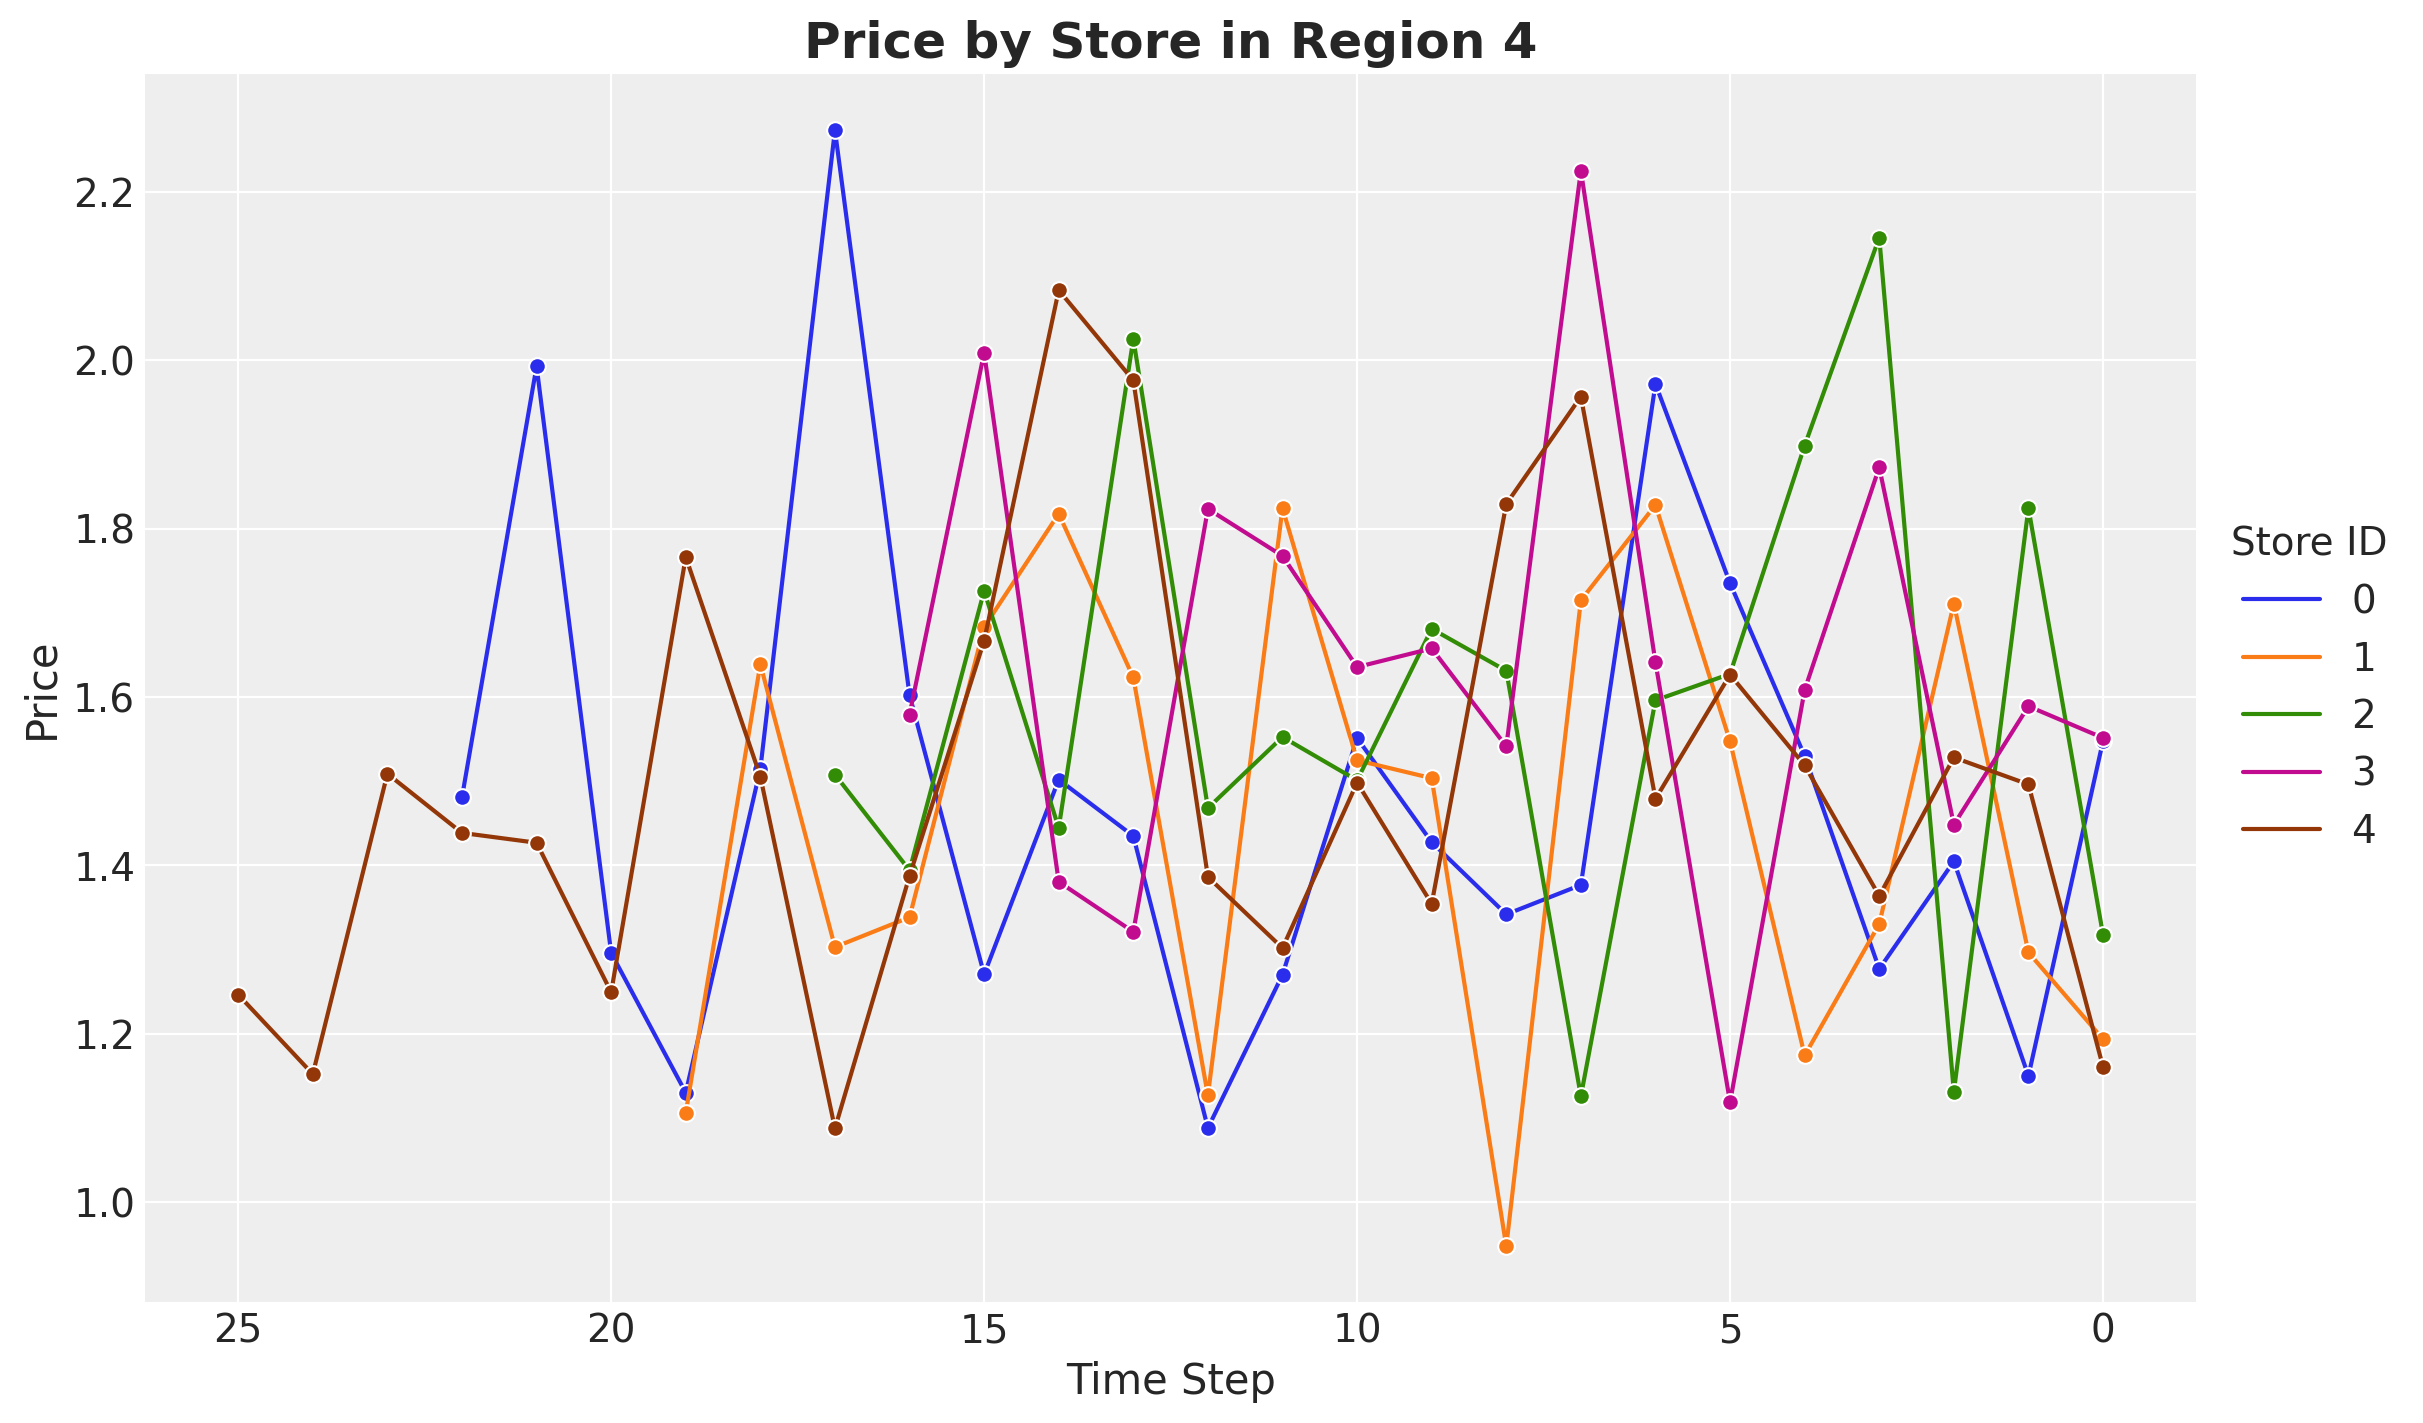

In [8]:
fig, ax = plt.subplots()
sns.lineplot(
    data=market_df.query("region_id == 4").assign(
        store_id=lambda x: x["store_id"].astype("category")
    ),
    x="time_step",
    y="price",
    hue="store_id",
    marker="o",
)
ax.invert_xaxis()
ax.legend(
    title="Store ID", title_fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5)
)
ax.set(xlabel="Time Step", ylabel="Price")
ax.set_title(label="Price by Store in Region 4", fontsize=18, fontweight="bold")

In [9]:
obs = market_df.index.to_numpy()
price = market_df["price"].to_numpy()
log_price = np.log(price)
sales = market_df["sales"].to_numpy()
log_sales = np.log(sales)
median_income_idx, median_income = market_df["median_income"].factorize(sort=True)
store_idx, store = market_df["region_store_id"].factorize(sort=True)
region_idx, region = market_df["region_id"].factorize(sort=True)

In [10]:
median_income

Index([ 5.691923918661068,  8.571094099453049, 12.003646109876465,
        14.49291727284113, 19.764104482755673],
      dtype='float64')

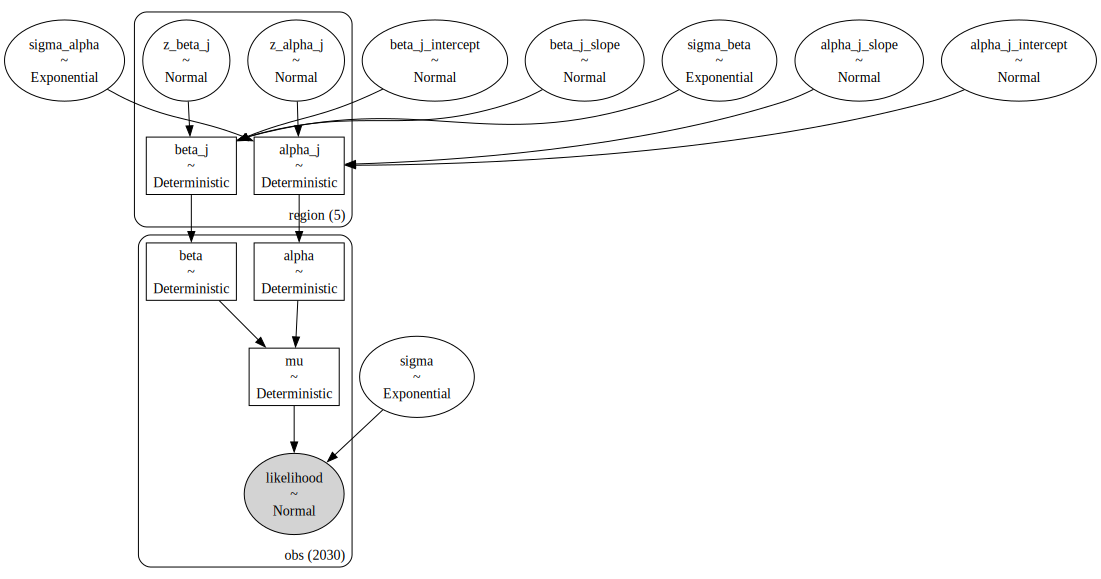

In [11]:
coords = {"store": store, "region": region, "obs": obs}

with pm.Model(coords=coords) as model:
    # --- Priors ---

    alpha_j_intercept = pm.Normal(name="alpha_j_intercept", mu=0, sigma=1)
    alpha_j_slope = pm.Normal(name="alpha_j_slope", mu=0, sigma=1)
    sigma_alpha = pm.Exponential(name="sigma_alpha", lam=1 / 0.1)
    z_alpha_j = pm.Normal(name="z_alpha_j", mu=0, sigma=1, dims="region")

    beta_j_intercept = pm.Normal(name="beta_j_intercept", mu=0, sigma=1)
    beta_j_slope = pm.Normal(name="beta_j_slope", mu=0, sigma=1)
    sigma_beta = pm.Exponential(name="sigma_beta", lam=1 / 0.1)
    z_beta_j = pm.Normal(name="z_beta_j", mu=0, sigma=1, dims="region")

    sigma = pm.Exponential(name="sigma", lam=1 / 0.5)

    # --- Parametrization ---

    alpha_j = pm.Deterministic(
        name="alpha_j",
        var=(
            alpha_j_intercept
            + (alpha_j_slope * median_income.to_numpy())
            + sigma_alpha * z_alpha_j
        ),
        dims="region",
    )

    beta_j = pm.Deterministic(
        name="beta_j",
        var=(
            beta_j_intercept
            + (beta_j_slope * median_income.to_numpy())
            + sigma_beta * z_beta_j
        ),
        dims="region",
    )

    alpha = pm.Deterministic(name="alpha", var=alpha_j[region_idx], dims="obs")
    beta = pm.Deterministic(name="beta", var=beta_j[region_idx], dims="obs")

    mu = pm.Deterministic(name="mu", var=alpha + beta * log_price, dims="obs")

    # --- Likelihood ---

    pm.Normal(name="likelihood", mu=mu, sigma=sigma, observed=log_sales, dims="obs")

pm.model_to_graphviz(model=model)

In [12]:
with model:
    idata = pm.sample(
        target_accept=0.9,
        draws=5_000,
        chains=5,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive = pm.sample_posterior_predictive(trace=idata, random_seed=rng)


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.604131
Sampling...


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Sampling time =  0:04:00.205452
Transforming variables...
Transformation time =  0:00:01.424331


Sampling: [likelihood]


In [13]:
idata["sample_stats"]["diverging"].sum().item()

0

In [14]:
var_names = [
    "alpha_j_intercept",
    "alpha_j_slope",
    "beta_j_intercept",
    "beta_j_slope",
    "alpha_j",
    "beta_j",
    "sigma",
]

az.summary(data=idata, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_j_intercept   1.272  1.001  -0.637    3.106      0.031    0.022   
alpha_j_slope       0.667  0.106   0.471    0.872      0.004    0.003   
beta_j_intercept   -1.537  0.986  -3.370    0.304      0.032    0.022   
beta_j_slope       -0.463  0.091  -0.638   -0.292      0.003    0.002   
alpha_j[0]          5.549  0.010   5.531    5.567      0.000    0.000   
alpha_j[1]         16.821  0.018  16.787   16.855      0.000    0.000   
alpha_j[2]         12.595  0.013  12.571   12.619      0.000    0.000   
alpha_j[3]          7.846  0.010   7.828    7.865      0.000    0.000   
alpha_j[4]         10.619  0.025  10.573   10.668      0.000    0.000   
beta_j[0]          -4.831  0.023  -4.873   -4.787      0.000    0.000   
beta_j[1]         -11.890  0.043 -11.969  -11.809      0.000    0.000   
beta_j[2]          -9.258  0.030  -9.313   -9.201      0.000    0.000   
beta_j[3]          -6.269  0.023  -6.314   -6.226      0.000    0.000   
beta_j[4]          -8.040  0.056  -8.146   -7.935      0.000    0.000   
sigma               0.101  0.002   0.098    0.104      0.000    0.000   

                   ess_bulk  ess_tail  r_hat  
alpha_j_intercept    1023.0    2314.0   1.00  
alpha_j_slope         584.0    1412.0   1.01  
beta_j_intercept      969.0    2342.0   1.00  
beta_j_slope          831.0    1682.0   1.01  
alpha_j[0]          25853.0   21449.0   1.00  
alpha_j[1]          24573.0   21402.0   1.00  
alpha_j[2]          25856.0   22310.0   1.00  
alpha_j[3]          25509.0   21567.0   1.00  
alpha_j[4]          25533.0   20890.0   1.00  
beta_j[0]           25955.0   19489.0   1.00  
beta_j[1]           24548.0   21265.0   1.00  
beta_j[2]           26083.0   20950.0   1.00  
beta_j[3]           25645.0   19713.0   1.00  
beta_j[4]           25302.0   20689.0   1.00  
sigma                2492.0    5038.0   1.00

Text(0.5, 0.98, 'Model - Trace')

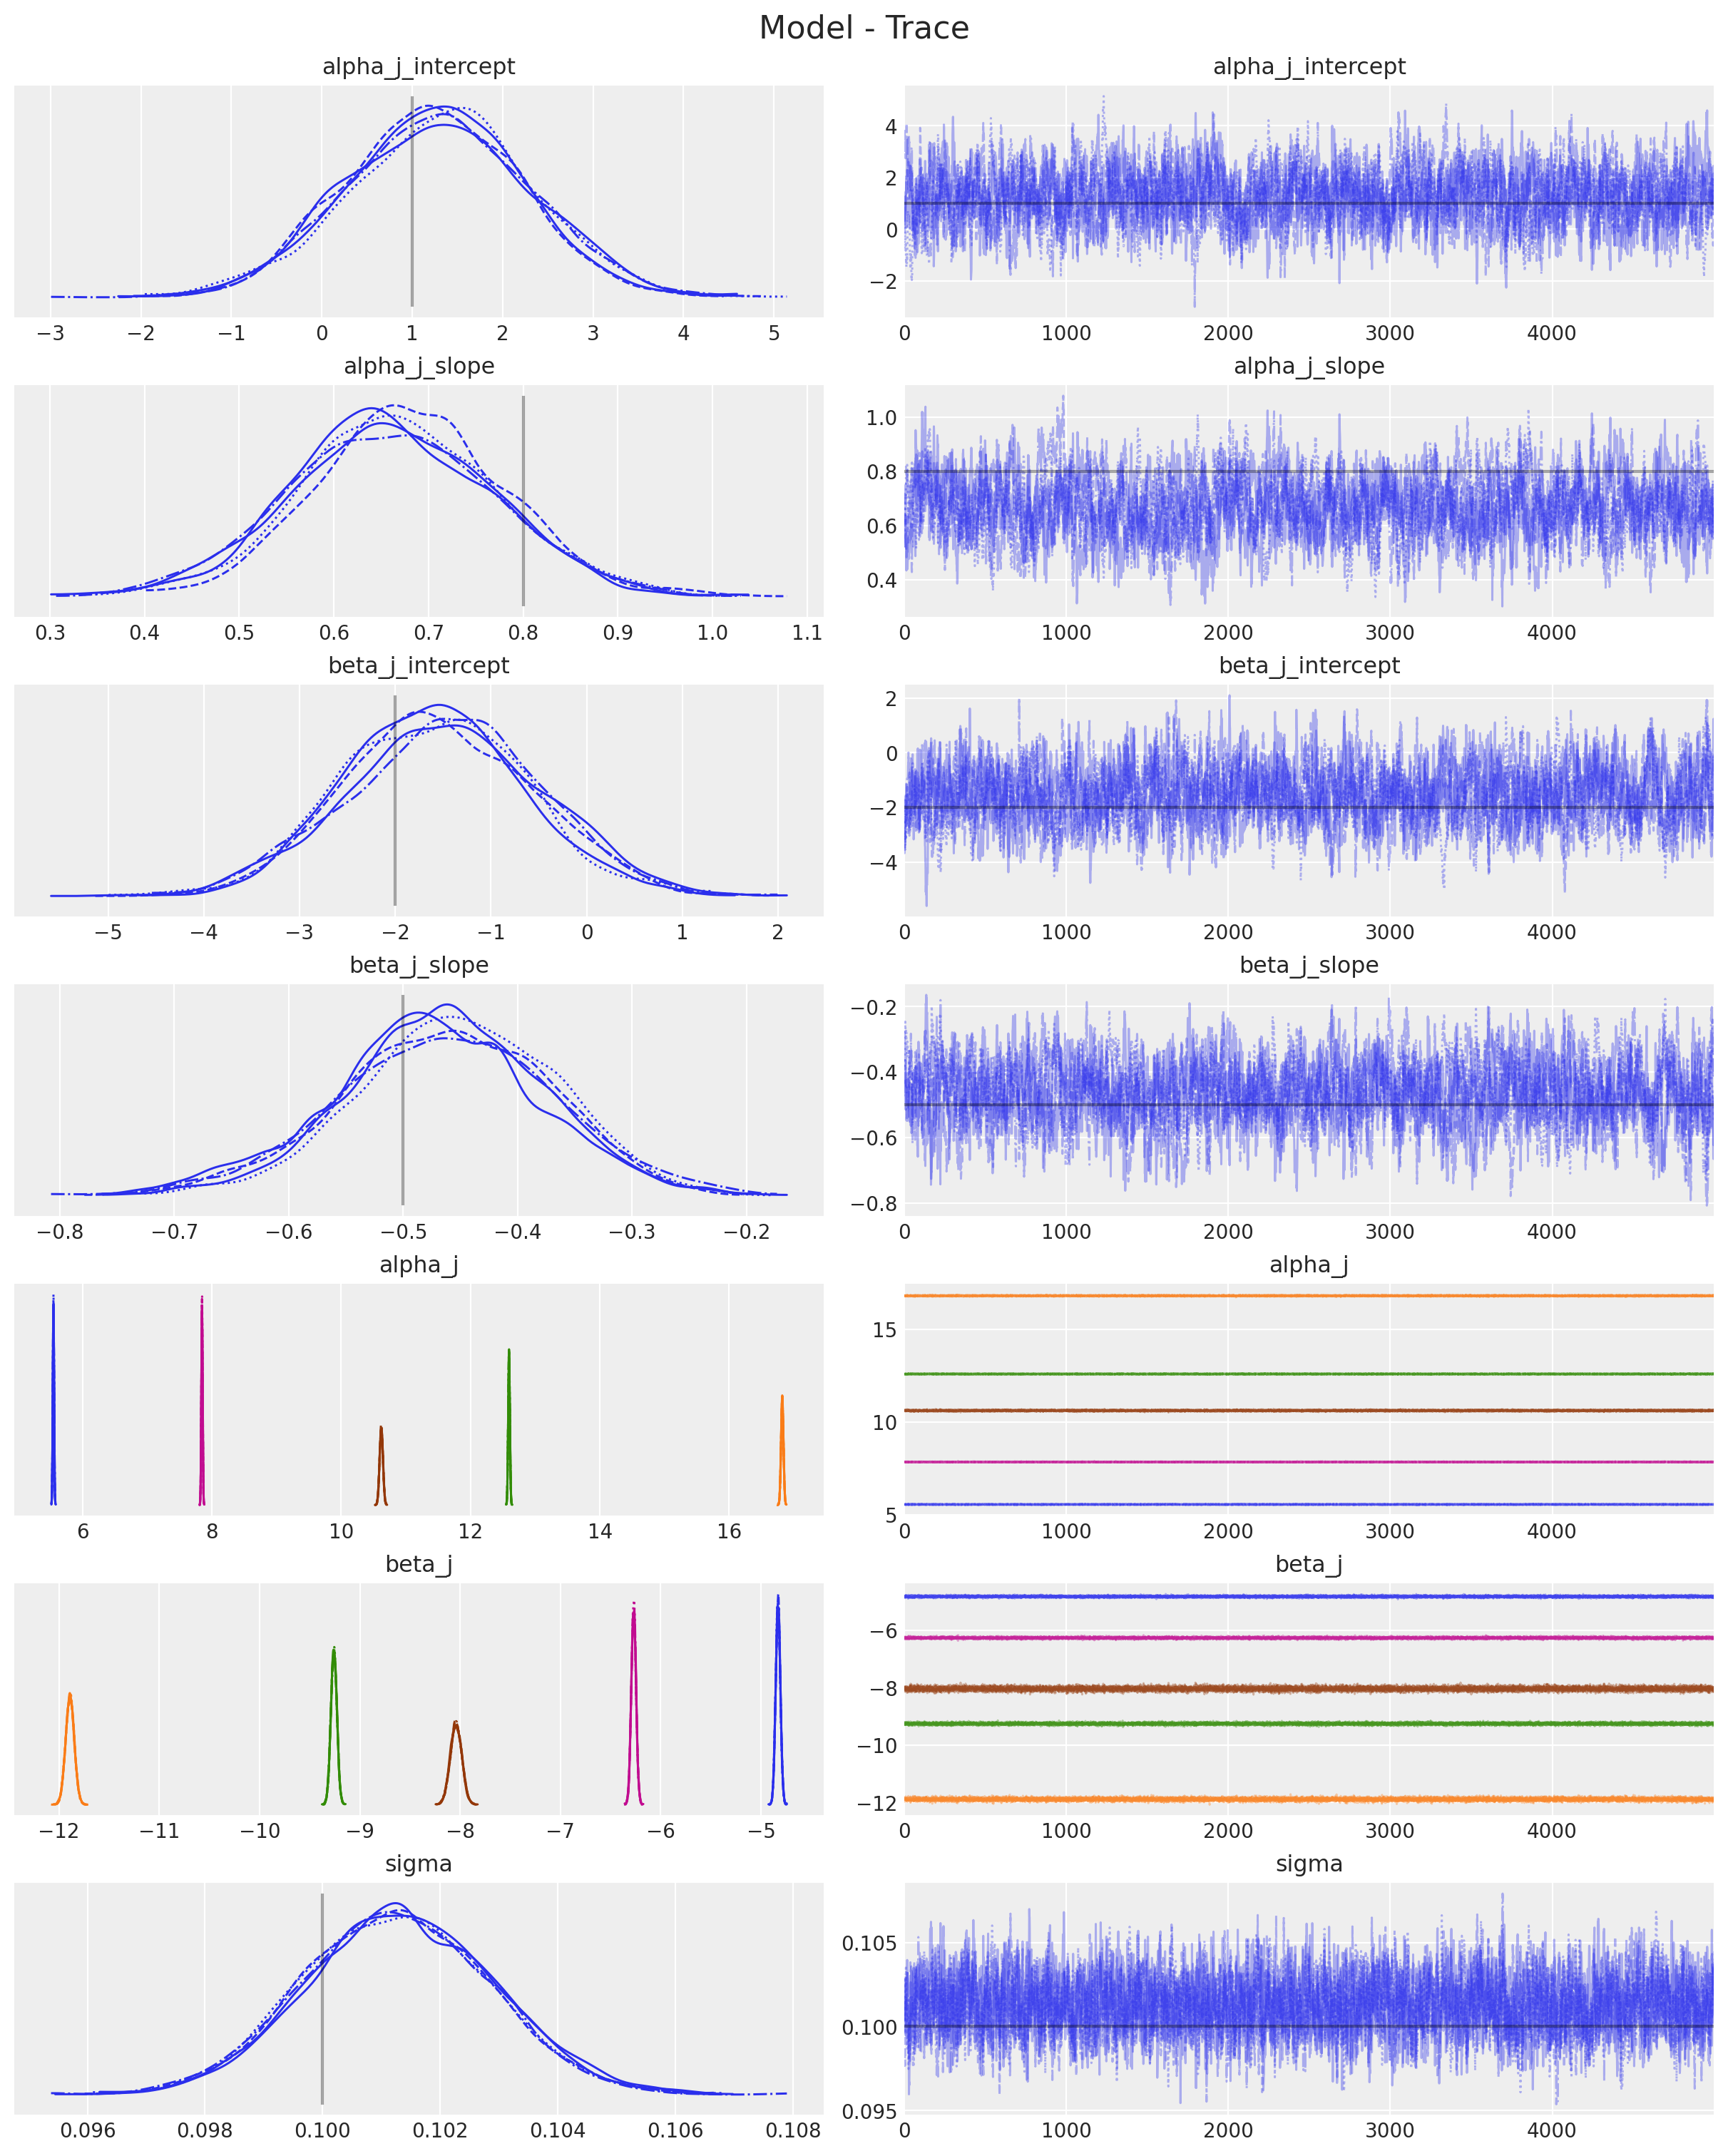

In [15]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    lines=[
        ("alpha_j_intercept", {}, data_generator.intercepts_lr_config.intercept),
        ("alpha_j_slope", {}, data_generator.intercepts_lr_config.slope),
        ("beta_j_intercept", {}, data_generator.slopes_lr_config.intercept),
        ("beta_j_slope", {}, data_generator.slopes_lr_config.slope),
        ("sigma", {}, data_generator.epsilon),
    ],
    compact=True,
    # kind="rank_bars",
    backend_kwargs={"figsize": (12, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model - Trace", fontsize=16)


array([[<Axes: ylabel='alpha_j_slope'>, <Axes: >, <Axes: >],
       [<Axes: ylabel='beta_j_intercept'>, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha_j_intercept', ylabel='beta_j_slope'>,
        <Axes: xlabel='alpha_j_slope'>,
        <Axes: xlabel='beta_j_intercept'>]], dtype=object)

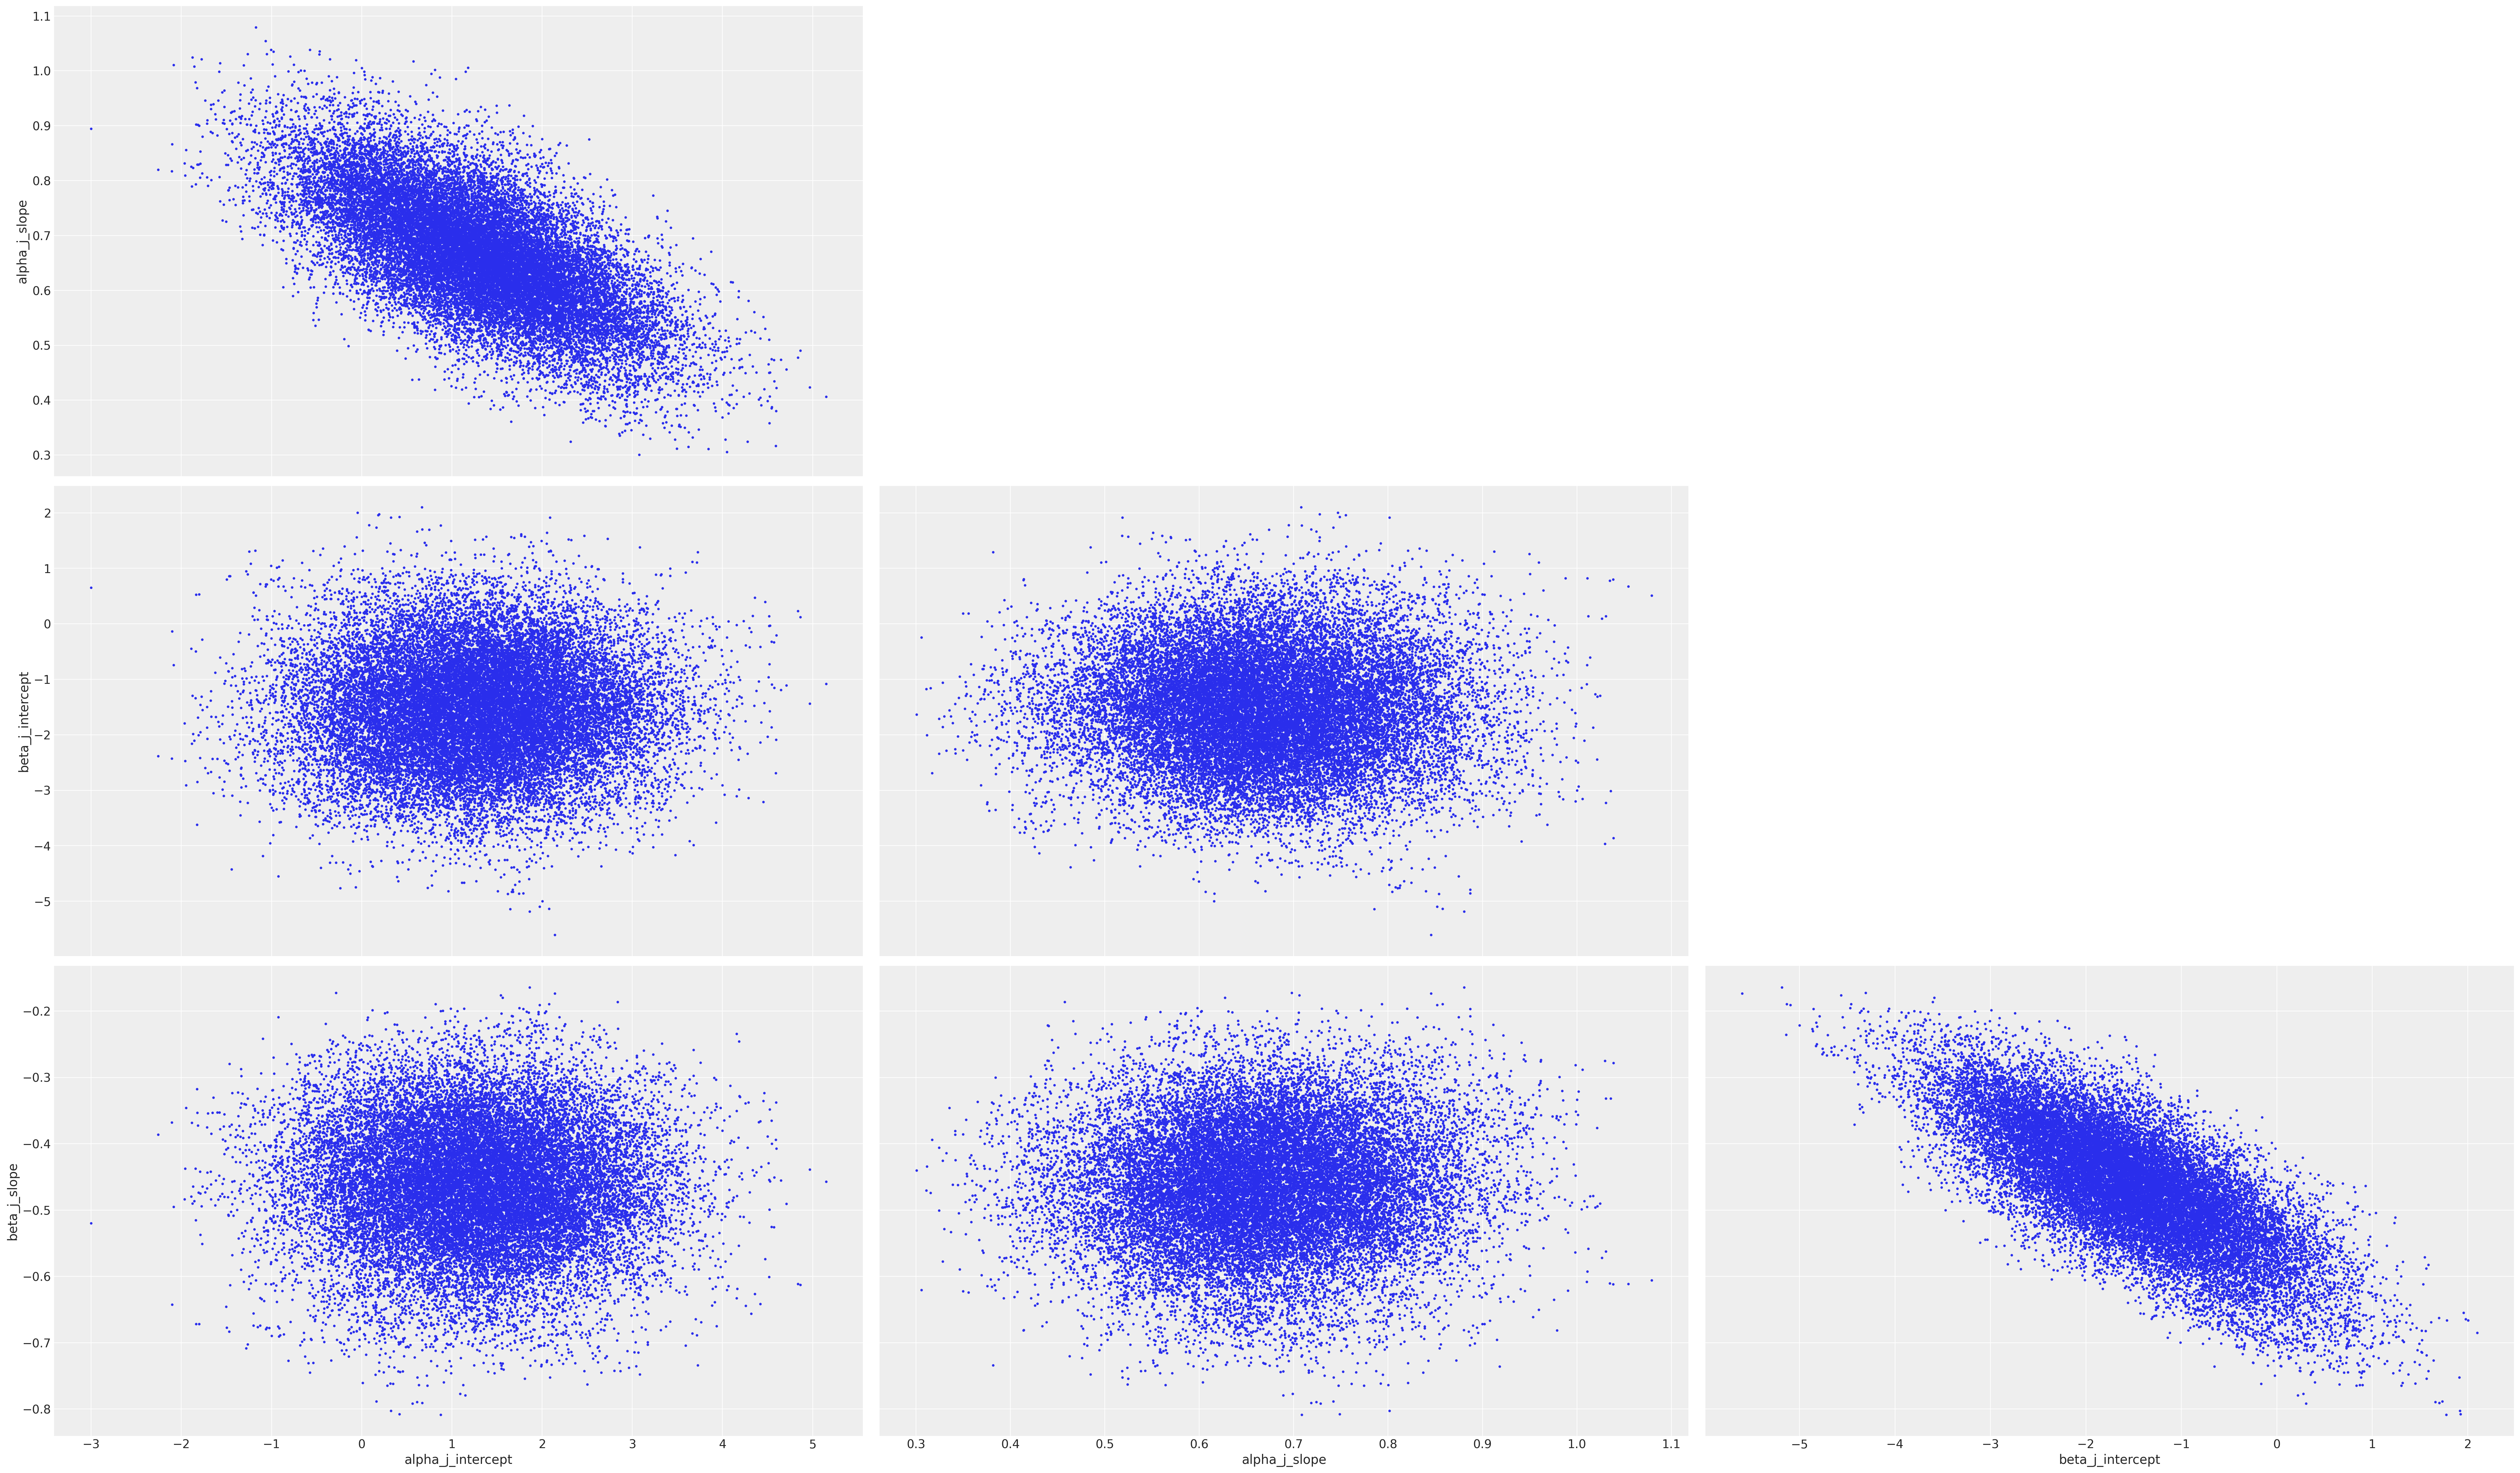

In [16]:
az.plot_pair(
    data=idata,
    var_names=[
        "alpha_j_intercept",
        "alpha_j_slope",
        "beta_j_intercept",
        "beta_j_slope",
    ],
)

[Text(0.5, 1.0, 'Posterior Predictive Check'), Text(0.5, 0, 'likelihood')]

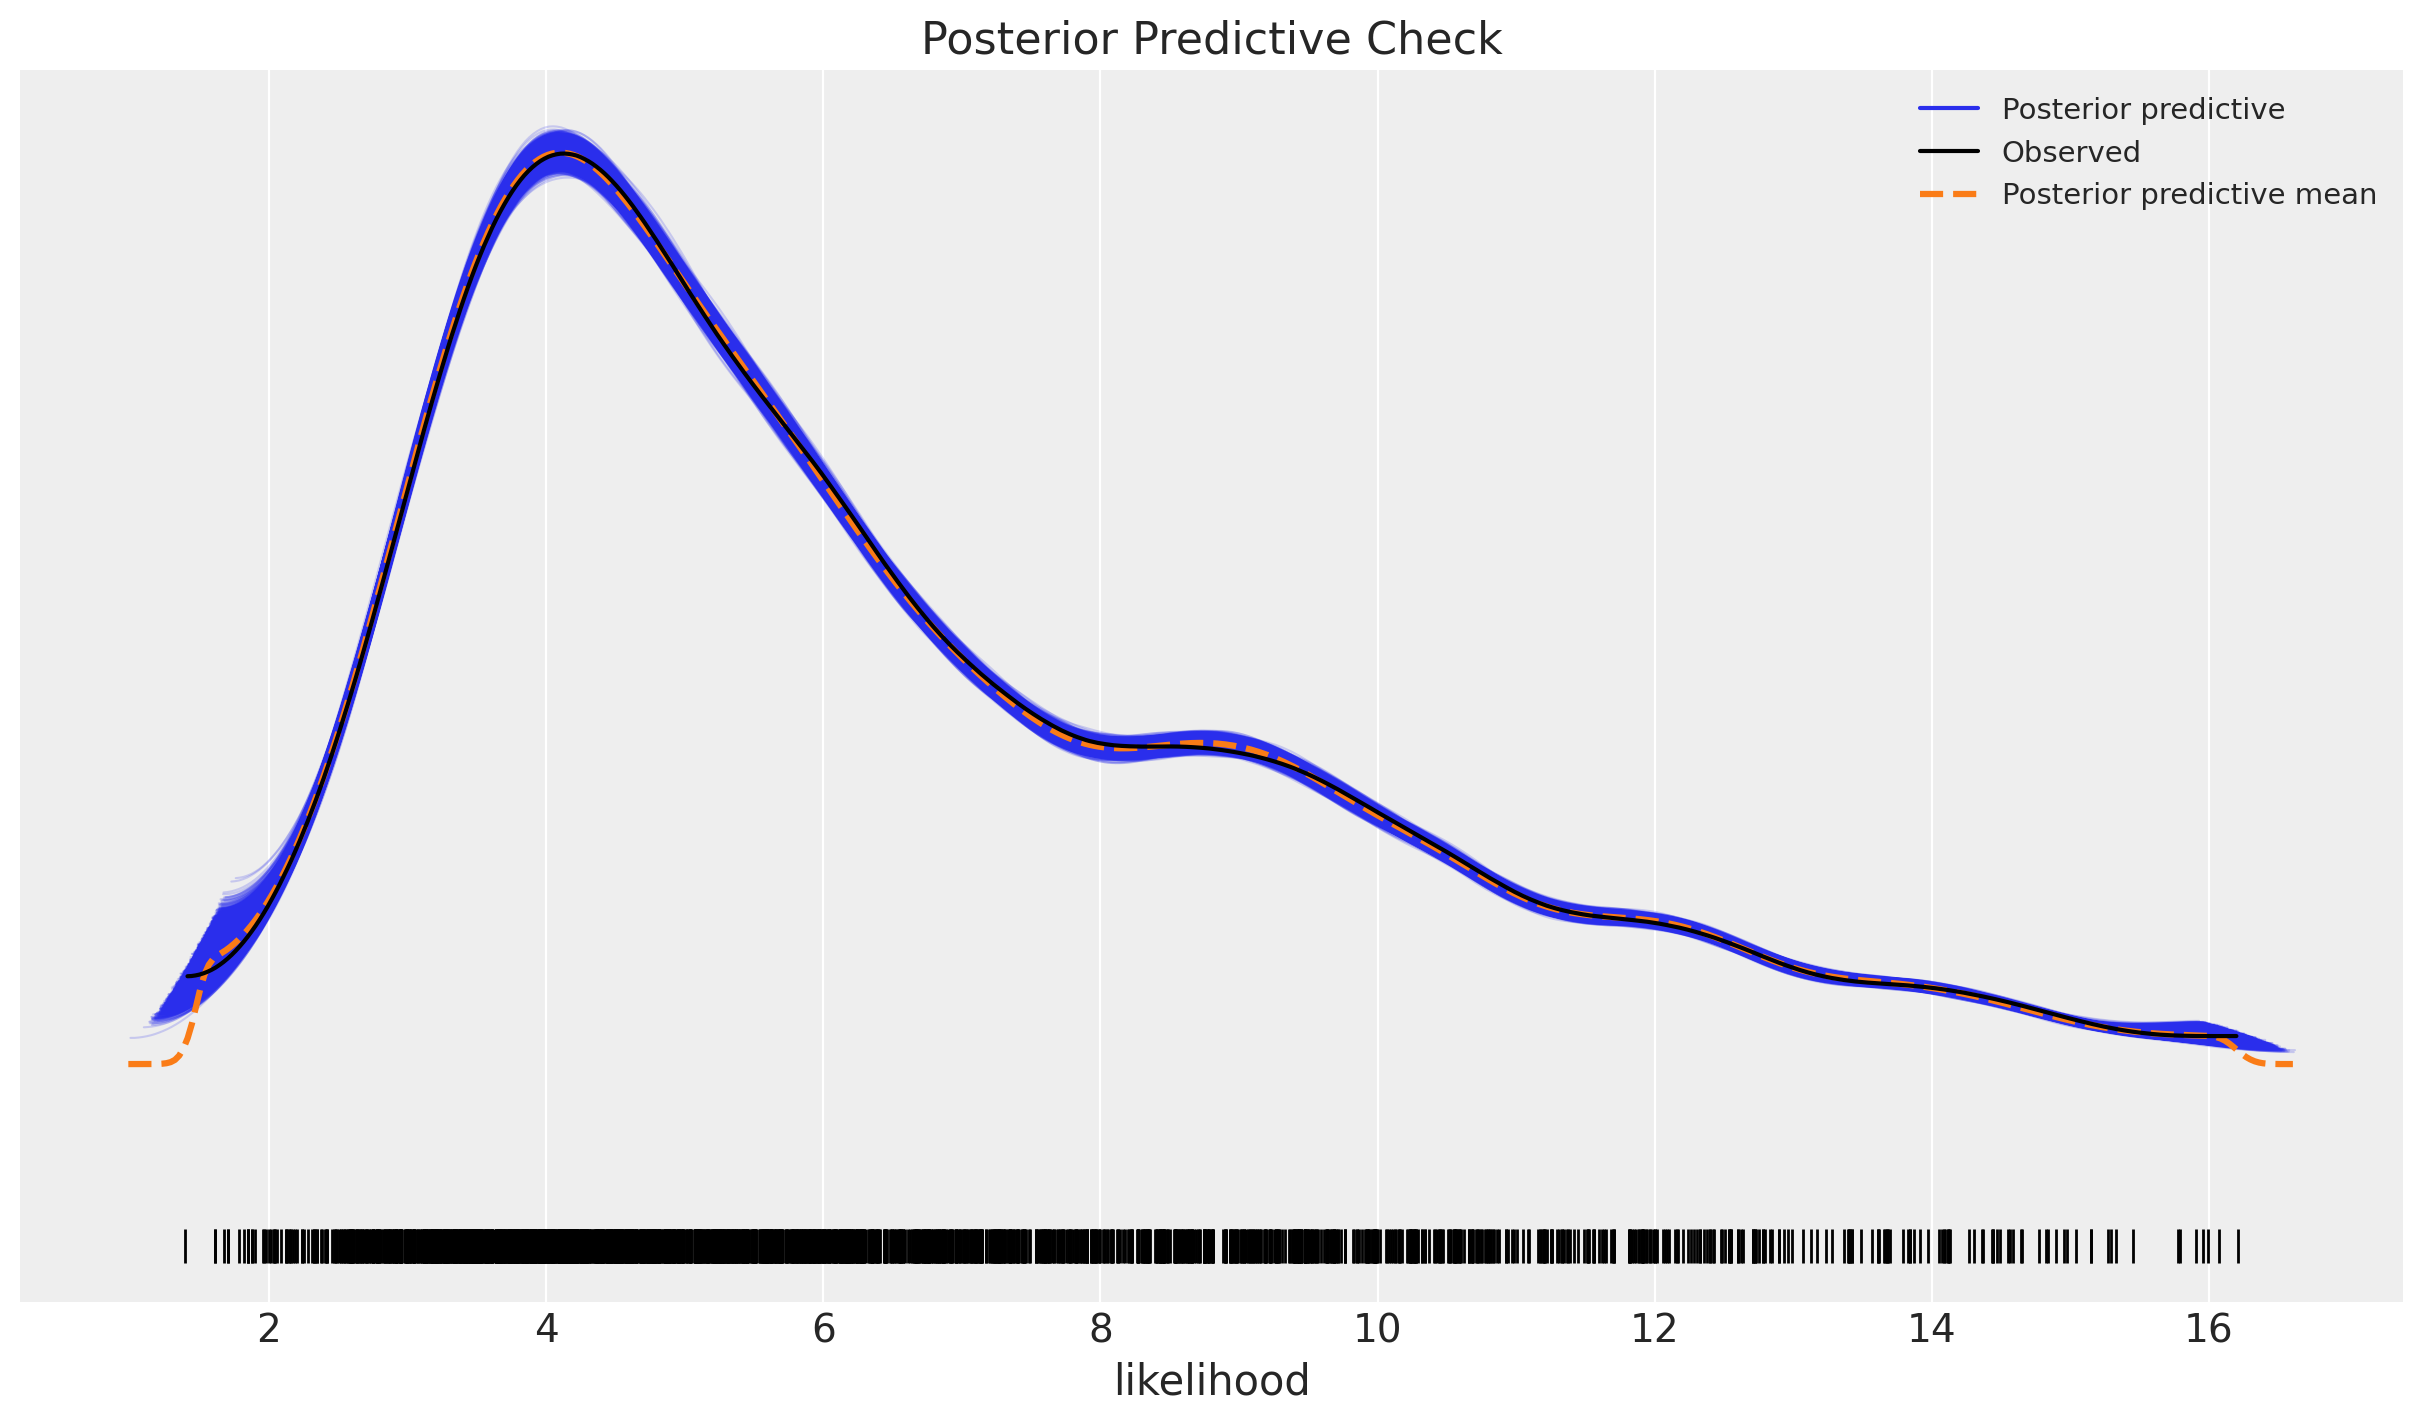

In [17]:
ax = az.plot_ppc(
    data=posterior_predictive,
    observed_rug=True,
    random_seed=seed,
)
ax.set(
    title="Posterior Predictive Check",
    xlabel="likelihood",
    # xlim=(-0.5, 1.5),
)